<h1 align="center">Determinación experimental de la impedancia de un circuito RC paralelo en serie con una resistencia</h1>
<div align="right">David A. Miranda, PhD<br>2023</div>

## 1. Cargar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from IPython.display import Latex

## 2. Planteamiento del problema

Realizar el montaje de un circuito con una resistencia $R_1$ en paralelo con un capacitor $C$ y ambos en serie con una resistencia $R_2 \geq 1k\Omega$. Conectar el circuito a un generador de señales, asegurándose que la referencia quede en la resistencia $R_2$ y obtener:
+ La curva corriente voltaje.
+ El espectro de impedancia eléctrica para un circuito RC paralelo en serie con una resistencia.

## 3. Métodos y definiciones

In [2]:
dpi = 300

In [3]:
def cole_cole(f, Xi, DX, tau, alpha):
    return Xi + DX / ( 1 + (2j*np.pi*f*tau)**(1-alpha) )

In [4]:
def optimize_tau(f, X, Xi, DX, tau, alpha, algorithm='least_squares'):
    def err(T):
        if T < 0:
            return 100
        X1 = cole_cole(f, Xi, DX, T, alpha)
        return sum(np.abs(X1 - X)**2)/sum(np.abs(X)**2)
    opt = np.nan
    if 'least_squares' in algorithm:
        opt = optimize.least_squares(err, tau, bounds=(0, np.inf))
    if 'basinhopping' in algorithm:
        opt = optimize.basinhopping(err, tau, niter=1000)
    return opt.x[0]

In [5]:
def get_cole_params(f, X, algorithm='least_squares', verbose=True):
    def f_2b(c):
        """ calculate the algebraic distance between the 2D points and the mean circle centered at c=(-xc, -yc, C) """
        A, B, C = c
        Xi = 100
        if A**2 >= C:
            R = np.sqrt(A**2 + B**2 - C)
            Xi = A + np.sqrt( A**2 - C )
        x = np.real(X)
        y = np.imag(X)
        r = x**2 + y**2 + 2*x*A + 2*y*B + C
        if Xi < 0:
            return 10*r
        return r
    x_m = np.mean(np.real(X))
    R0  = ( max(np.real(X)) - min(np.real(X)) )/2.0
    y_m = max(np.abs(np.imag(X))) - R0
    C0  =  x_m**2 + y_m**2 - R0**2
    ABC = -x_m, -y_m, C0
    ABC_opt, ier = optimize.leastsq(f_2b, ABC)
    A, B, C = ABC_opt
    R = np.sqrt(A**2 + B**2 - C) # (y + B)^2 + (x + A)^2 = R^2
    if R**2 < B**2:
        if verbose:
            print('Warning! The Cole-Cole inversion fails.')
        return np.nan, np.nan, np.nan, np.nan
    DX = 2 * np.sqrt( R**2 - B**2 )
    Xi1 = -A - DX/2
    Xi2 =  A + DX/2
    Xmax = R - B
    phi = np.arctan(-2*B/DX)
    alpha = 2 * phi / np.pi

    def get_tau(Xi):
        # Obtention of tau #
        k = min(range(len(f)), key=lambda i: abs(-np.imag(X)[i] - Xmax))
        fc = f[k]
        if type(fc) == type([]):
            fc = fc[0]
        if DX/(DX+Xi) < 0:
            return 1
        return np.sqrt(DX/(DX+Xi))/(2*np.pi*fc)

    X1 = cole_cole(f, Xi1, DX, get_tau(Xi1), alpha)
    X2 = cole_cole(f, Xi2, DX, get_tau(Xi2), alpha)
    Xi = Xi1
    tau = get_tau(Xi1)
    if sum(np.abs(X1 - X)**2) > sum(np.abs(X2 - X)**2):
        Xi = Xi2
        tau = get_tau(Xi2)

    tau_opt = optimize_tau(f, X, Xi, DX, tau, alpha, algorithm=algorithm)
    X1 = cole_cole(f, Xi1, DX, tau, alpha)
    X2 = cole_cole(f, Xi2, DX, tau_opt, alpha)
    if not np.isnan(tau_opt) and sum(np.abs(X1 - X)**2) > sum(np.abs(X2 - X)**2):
        tau = tau_opt

    return Xi, DX, tau, alpha

In [6]:
def get_fitted_curve(f, X, algorithm='least_squares', verbose=True):
    Xi, DX, tau, alpha = get_cole_params(f, Z, algorithm=algorithm, verbose=verbose)
    ffit = np.logspace(np.log10(min(f)), np.log10(max(f)), 1000)
    if verbose:
        Xi_, DX_, tau_, alpha_ = round(Xi, 1), round(DX, 1), round(tau*1e6, 3), round(alpha, 3)
        Z_latex = Latex(r'$Z = {} + \frac{{{}}}{{1 + (j{}\times 10^{{-6}}\,\omega)^{{{}}}}}$'.format(Xi_, DX_, tau_, 1-alpha_))
        display(Z_latex)
    return ffit, cole_cole(ffit, Xi, DX, tau, alpha)

In [7]:
def plot_cv(data, id=1):
    t = 1e-6 * data['Timestamps (ns)'].to_numpy()
    v = data['1'].to_numpy()
    i = data['2'].to_numpy()/R2

    plt.figure(dpi=dpi)
    plt.plot(v, 1000*i, '.', alpha=0.4)
    plt.xlabel('Voltaje [V]')
    plt.ylabel('Corriente [mA]')
    _ = plt.title('Figura %d. Curva corriente voltaje (CV)' % id)

In [8]:
def plot_time(data, id=2):
    t = 1e-6 * data['Timestamps (ns)'].to_numpy()
    v = data['1'].to_numpy()
    i = data['2'].to_numpy()/R2
    plt.figure(dpi=dpi)
    plt.plot(t, v, '.', label='Voltaje [V]')
    plt.plot(t, 1000*i, '.', label='Corriente [mA]')
    plt.xlabel('Tiempo [ms]')
    plt.legend()
    _ = plt.title('Figura %d. Señales de corriente y voltaje.' % id)

In [9]:
def get_impedance(data_list, R2):
    eis_data = pd.DataFrame(data_list[1:], columns=data_list[0])
    φ = 1e-6 * 2 * np.pi * ( eis_data['Δt [µs]'] * eis_data['Frecuencia [Hz]']).to_numpy()
    f = eis_data['Frecuencia [Hz]'].to_numpy()
    Z_magn = (eis_data['V1 [V]'] / ( eis_data['V2 [V]'] / R2 )).to_numpy()
    Z_real = Z_magn * np.cos(φ)
    Z_imag = Z_magn * np.sin(φ)
    return f, Z_real + 1j * Z_imag

In [10]:
def plot_bode(f, Z, ffit=None, Zfit=None, id=3, dpi=dpi):
    plt.figure(dpi=dpi)
    plt.semilogx(f, Z.real, '.', color='blue', label=r"$Z'$  $[\Omega]$")
    plt.semilogx(f,-Z.imag, 's', color='orange', label=r"$Z''$  $[\Omega]$")
    if not ffit is None and not Zfit is None:
        plt.semilogx(ffit, Zfit.real, color='blue', lw=1)
        plt.semilogx(ffit, -Zfit.imag, color='orange', lw=1)
    plt.xlabel('Frecuencia [Hz]')
    plt.legend()
    _ = plt.title('Figura %d. Espectro de impedancia eléctrica.' % id)

In [11]:
def plot_nyquist(Z, Zfit=None, id=4, dpi=dpi):
    plt.figure(dpi=dpi)
    if Zfit is None:
        plt.plot(Z.real, -Z.imag, '.')
    if not Zfit is None:
        plt.plot(Z.real, -Z.imag, 'ob', label='Datos experimentales')
        plt.plot(Zfit.real, -Zfit.imag, 'b', lw = 1, label='Ajuste al modelo de Cole-Cole')
        plt.legend()
    plt.xlabel(r"$Z'$  $[\Omega]$")
    plt.ylabel(r"$Z''$  $[\Omega]$")
    plt.axis('equal')
    _ = plt.title('Figura %d. Diangrama de Nyquist.' % id)

## 4. Adquisición y procesamiento de los datos

### 4.1. Construcción del circuito y conexiones eléctricas

Se construyó un circuito eléctrico con un capacitor $C$ en paralelo con una resistencia, $R_1$ y el circuito resultando en serie con una resistencia $R_2$. Utilice un generador de señales para excitar el circuito y se conectó un terminal del osciloscopio a la fuente de excitación de voltaje $v(t)$ y el otro terminal (referencia), a la resistencia. Se tuvo cuidado en conectar la referencia tanto del generador de señales como del osciloscopio a la resistencia $R_2$.

### 4.2. Curva corriente voltaje

Se excitó el circuito con una señal triangular y capturaron las señales de voltaje del generador de señales $v(t)$ y de la resistencia $R_2$, $v_R(t)$. A continuación, se graficó la corriente que circula por el circuito en función del voltaje de excitación, así como las señales en el tiempo.

In [12]:
R2 = 100 # Ohm
data_file = 'https://raw.githubusercontent.com/davidalejandromiranda/fisicoquimica/master/data/CircuitoDummy_ExcitacionTriangular_1kHz.csv'
cv_data = pd.read_csv(data_file,
                      skiprows=20)

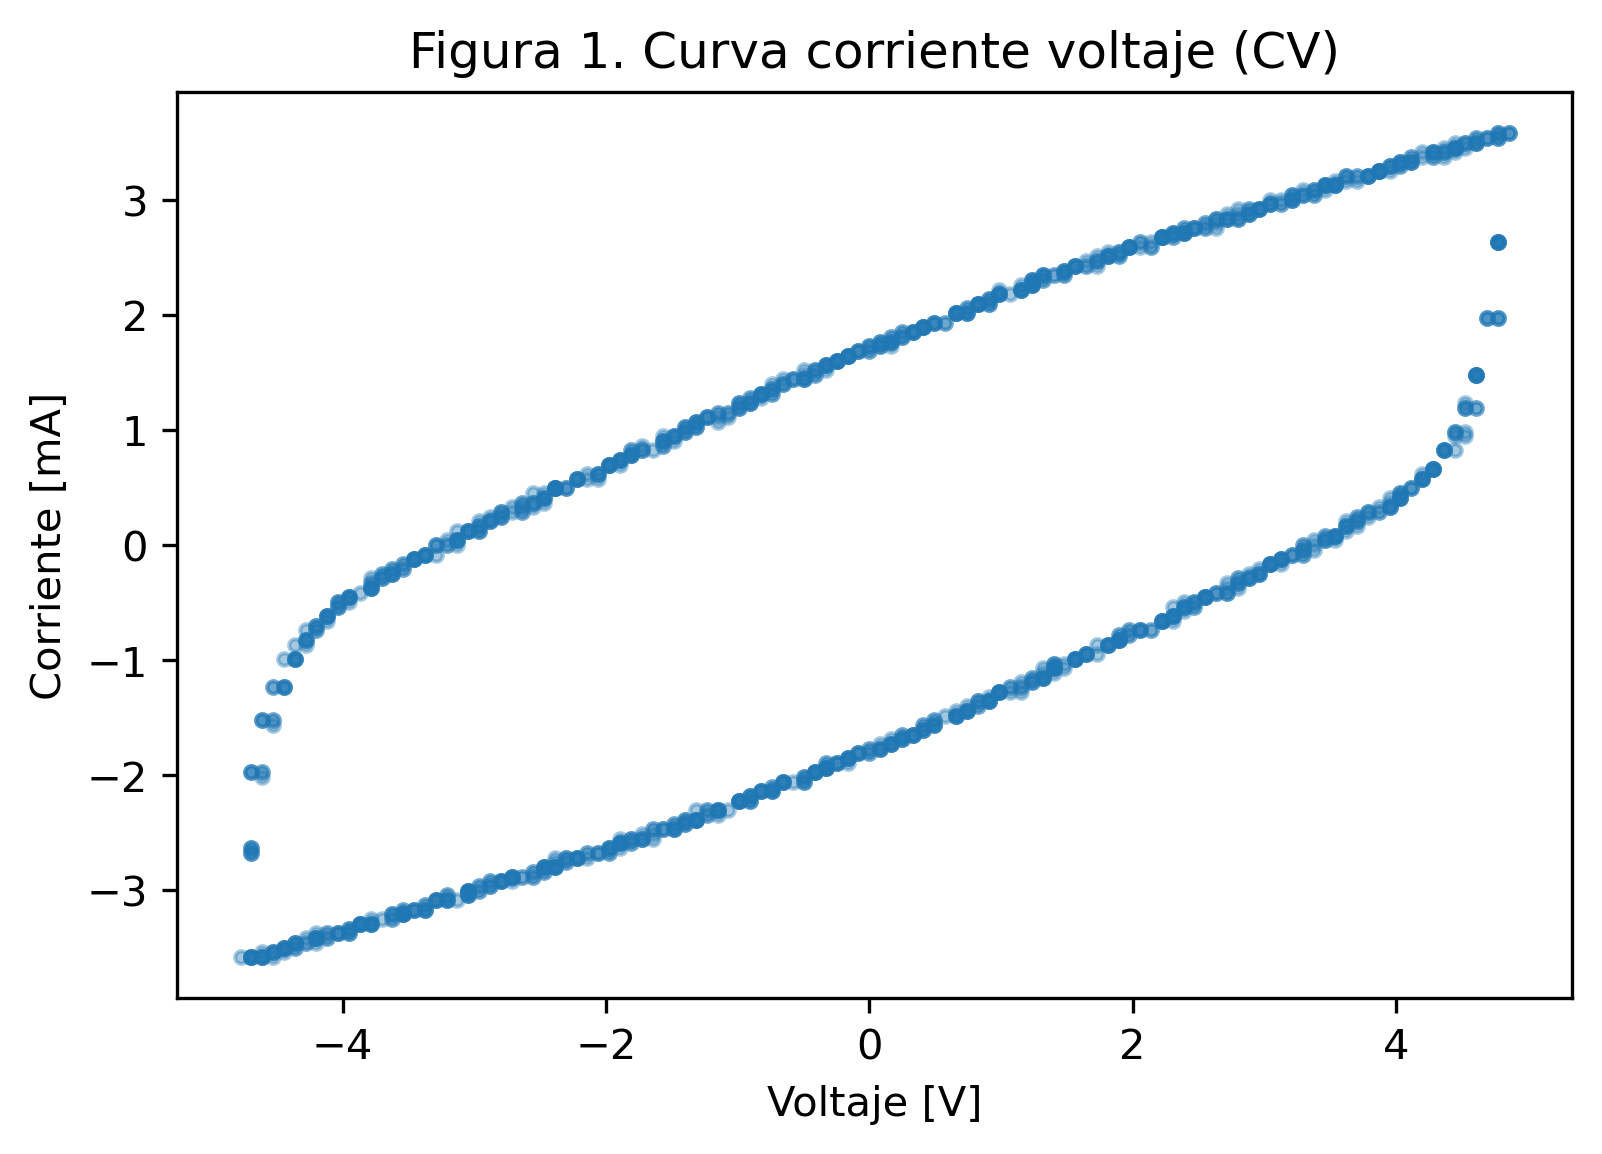

In [13]:
plot_cv(cv_data, id=1)

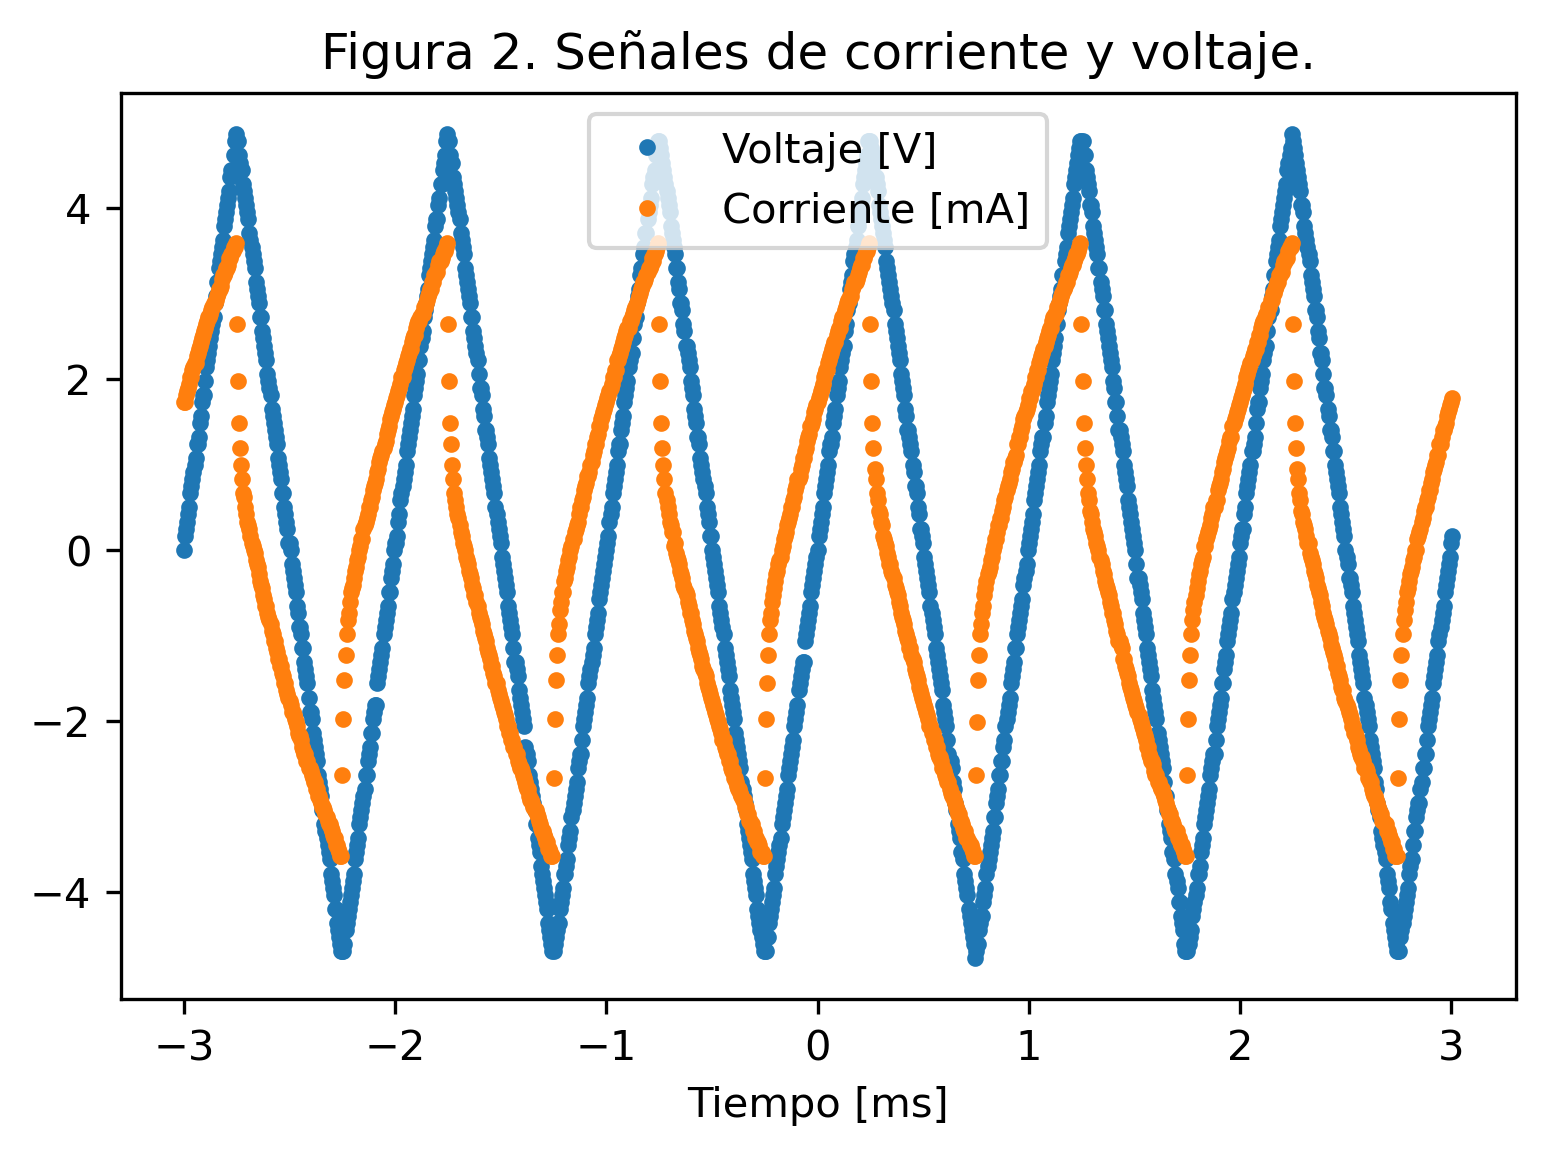

In [14]:
plot_time(cv_data, id=2)

## 4.3. Espectro de impedancia eléctrica

Se excitó el circuito con una señal sinusoidal '$v_1=V_1 sin(2\pi ft)$' y se determinaron las amplitudes las señales de voltaje del generador de señales $V_1$ y en la resistencia $V_2$. A continuación, se calculó la parte real $Z'$ e imaginaria $Z''$ de la impedancia eléctrica y se realizaron las gráficas correspondientes.

In [15]:
R2 = 2200
data_list = [
    ['Frecuencia [Hz]', 'V1 [V]', 'V2 [V]', 'Δt [µs]'],
    [    154,     2.49,      1.27,      -148.09],
    [    278,     2.49,      1.32,      -128.77],
    [    578,     2.49,      1.44,      -78.337],
    [   1074,     2.49,      1.73,      -43.997],
    [   1274,     2.49,      1.81,      -41.851],
    [   1574,     2.49,      1.93,      -37.559],
    [   2154,     2.49,      2.10,      -20.389],
    [   3154,     2.49,      2.26,      -9.6579],
    [   4154,     2.49,      2.30,      -6.4386],
    [   5995,     2.49,      2.34,      -4.2924],
    [   6995,     2.49,      2.39,      -2.3608],
    [   7995,     2.45,      2.43,      -1.0699],
    [   8995,     2.45,      2.43,      -1.0699],
    [   9995,     2.45,      2.43,      -1.0699],
    [  10995,     2.45,      2.43,      -0.42602],
    [  12995,     2.45,      2.43,      -0.64064],
    [  14995,     2.45,      2.43,      -0.64064],
    [  16681,     2.45,      2.43,      -0.42924],
    [  20995,     2.45,      2.43,      -0.00322],
    [  26995,     2.45,      2.43,      -0.05688],
    [  33995,     2.45,      2.43,      -0.21784],
    [  40995,     2.45,      2.43,      -0.16419],
    [  46416,     2.45,      2.47,      -0.05366],
    [  50995,     2.45,      2.47,      -0.05045],
    [  60995,     2.45,      2.43,      -0.16419],
    [  70995,     2.45,      2.43,      -0.07834],
    [  80995,     2.45,      2.43,      -0.12126],
    [  90995,     2.45,      2.43,      -0.05688],
    [ 100995,     2.45,      2.43,      -0.01395],
    [ 110995,     2.45,      2.43,      -0.00322],
    [ 120995,     2.45,      2.43,      -0.01395],
    [ 129155,     2.45,      2.43,      -0.03219],
    [ 140995,     2.45,      2.43,      -0.00322],
    [ 150995,     2.45,      2.43,      -0.00322],
    ]

In [16]:
f, Z = get_impedance(data_list, R2)
ffit, Zfit = get_fitted_curve(f, Z)

<IPython.core.display.Latex object>

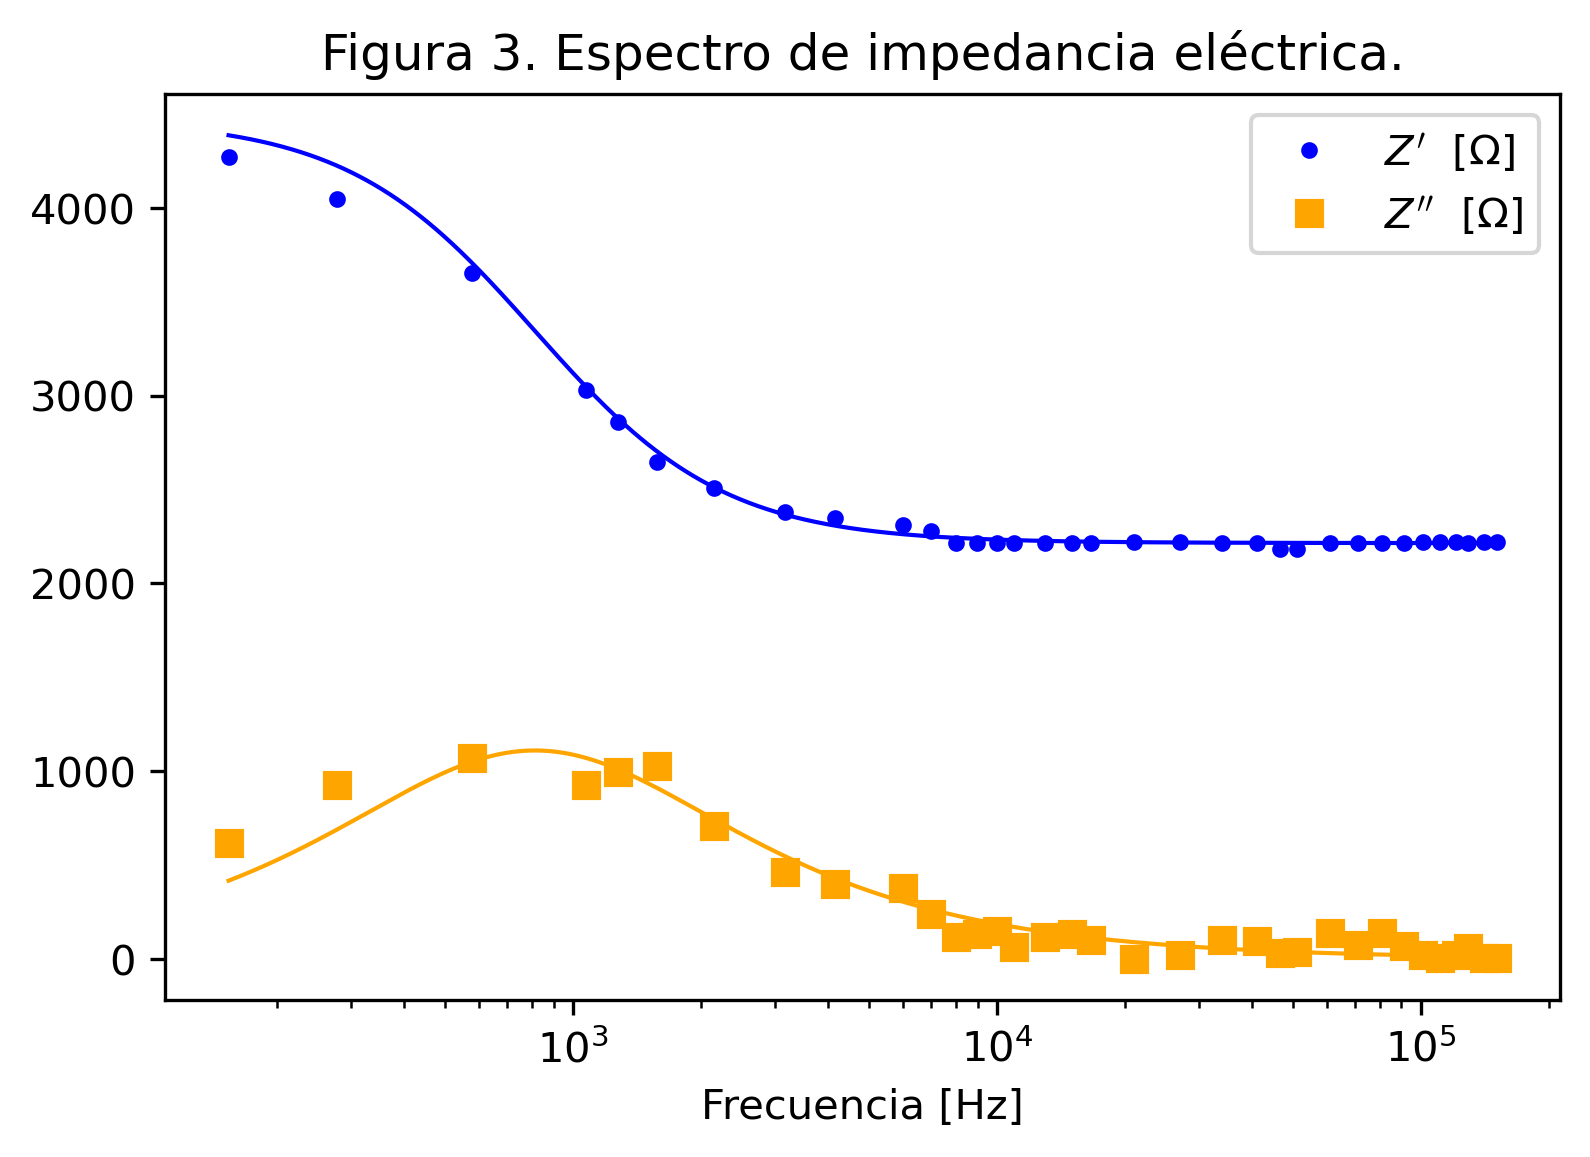

In [17]:
plot_bode(f, Z, ffit=ffit, Zfit=Zfit, id=3)

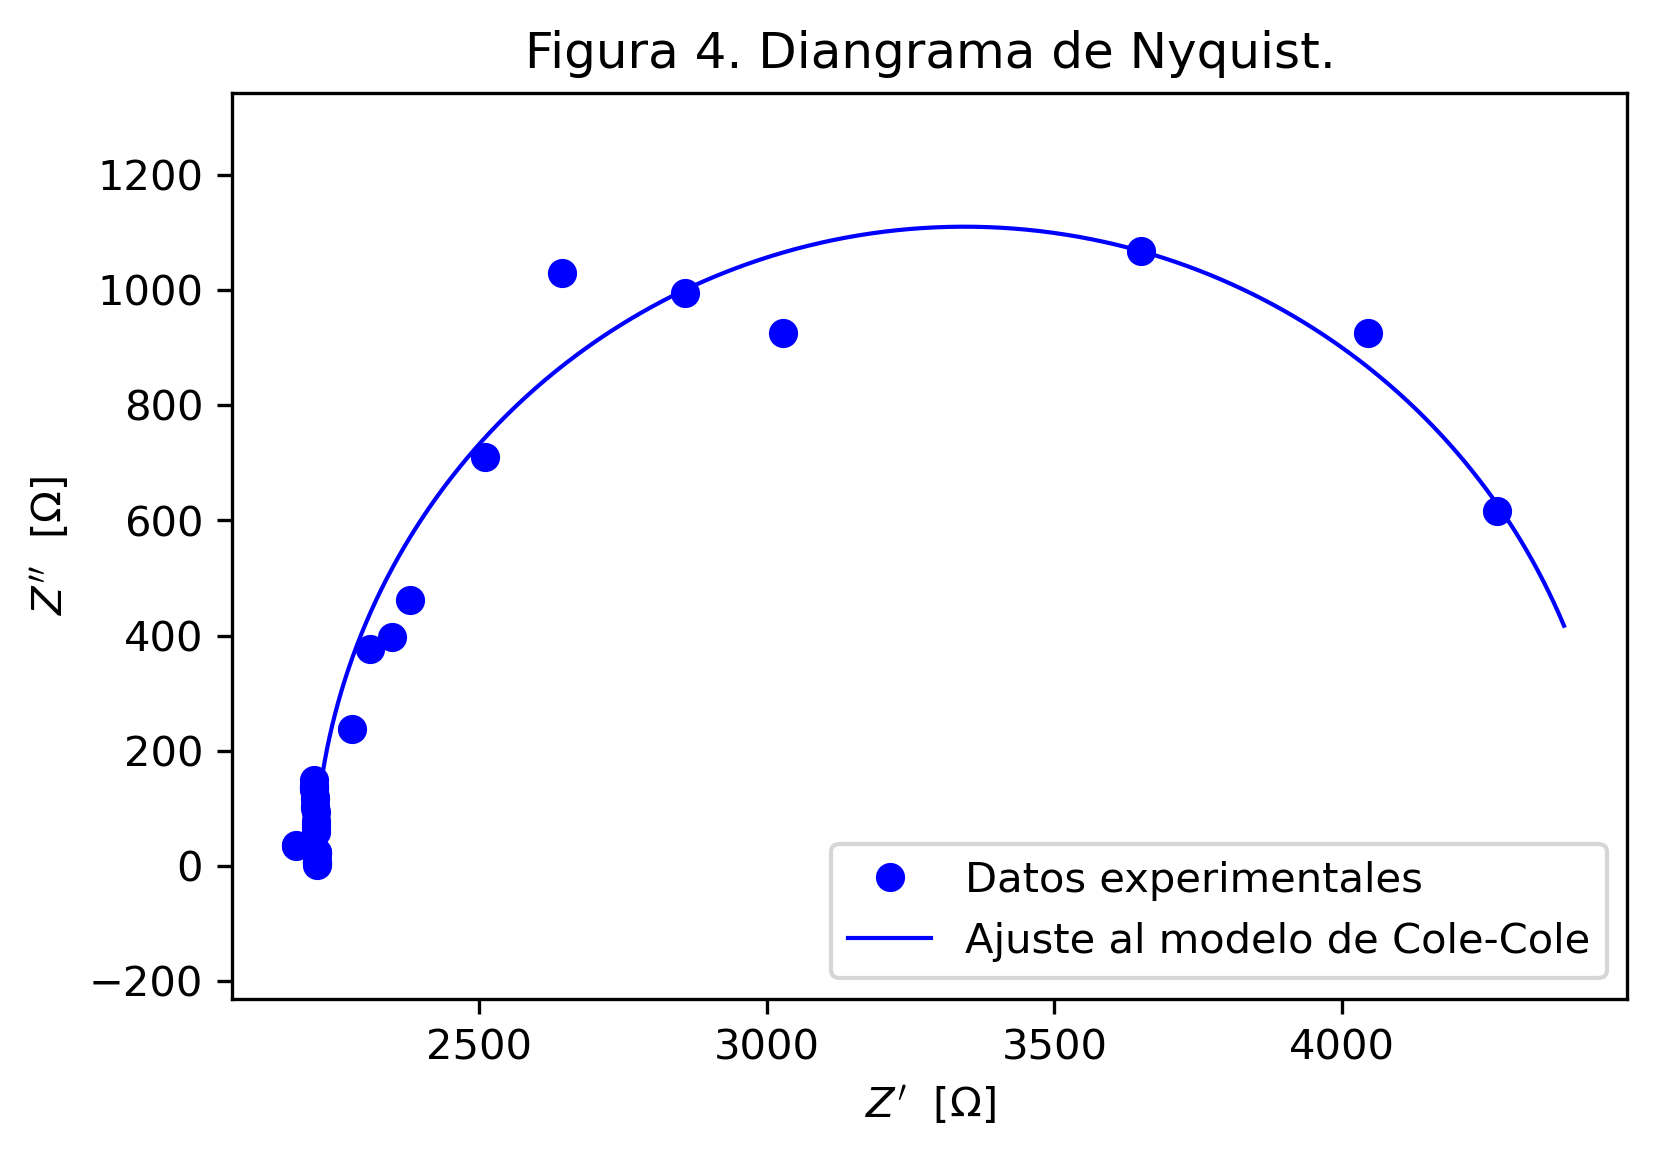

In [18]:
plot_nyquist(Z, Zfit=Zfit, id=4)

## 5. Preguntas de autoexplicación

### 5.1. Primer bloque de preguntas

5.1.1. Describa el propósito de importar cada una de las librerías, ver ítem 1.

5.1.2. Con sus propias palabras, describa el problema resuelto en este *Worked Example*. En su respuesta incluya un dibujo del circuito eléctico, además de los valores de los elementos circuitales utilizados.

5.1.3. Siga las instrucciones de la [actividad de refuerzo](https://colab.research.google.com/github/davidalejandromiranda/fisicoquimica/blob/master/impedancia/impedancia_def_refuerzo.ipynb) y reporte los resultados obtenidos.


### 5.2. Segundo bloque de preguntas

En el experimento para obtener la curva corriente voltaje del ítem 4.2:

5.2.1. Explique cómo se obtiene el valor de la corriente que circula por el circuito.

5.2.2. Describa el efecto de variar la frecuencia de la señal triangular.

5.2.3. En este ejemplo se usaron datos cargados en GitHub (ver *data_file*); realice las modificaciones necesarias para que usted pueda cargar los datos adquiridos en el laboratorio y explique cómo lo hizo.

5.2.4. En las Figuras 1 y 2 se muestra la misma información en dos representaciones diferentes. Describa cómo se relacionan ambas figuras e interprete la información que las mismas muestran.

5.2.5. ¿Éxiste alguna forma de obtener el espectro de impedancia eléctrica a partir de los datos de corriente y voltaje obtenidos? De ser así, grafique el espectro de impedancia eléctrica.

## 5.3. Tercer bloque de preguntas

En el experimento para obtener el espectro de impedancia eléctrica del ítem 4.3:

5.3.1. Obtenga los datos para completar la tabla *data_list*.

5.3.2. Describa cómo se calcula la corriente que circula por el circuito. Realice esquemas y deduzca las ecuaciones correspondientes.

5.3.3. Describa cómo se calcula el desfase entre la corriente y el voltaje.

5.3.4. Describa cómo, a partir de los datos experimentales, se calcula la parte real $Z'$ y la imaginaria $Z''$ de la impedancia eléctrica.

5.3.5. Compare los resultados experimentales obtenidos con las predicciones teóricas. En su comparación, construya una gráfica donde muestre la comparación y describa lo obtenido.

End!